In [19]:
import math
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import Counter
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import random

from scheduler import scheduler

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 3)

random.seed(42)

In [20]:
# Open data
df = pd.read_csv('data/US-NW-PACE_2024_hourly.csv')
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'], format='%m/%d/%Y')

df = df.rename(columns={
    'Datetime (UTC)': 'Timestamp',
    'Carbon intensity gCO₂eq/kWh (direct)': 'CI'
})

df['hour'] = df.groupby(df['Timestamp'].dt.date).cumcount()

# Create proper datetime with hours
df['Timestamp'] = df['Timestamp'] + pd.to_timedelta(df['hour'], unit='h')

df = df[['Timestamp', 'CI']].sort_values('Timestamp').reset_index(drop=True)
#df = df[(df['Timestamp'].dt.month == 10) & (df['Timestamp'].dt.year == 2024)]
df = df.reset_index(drop=True)

min_ts = df['Timestamp'].min()
max_ts = df['Timestamp'].max()

min_ci = df['CI'].min()
max_ci = df['CI'].max()

print("Min CI in dataset:", min_ci)
print("Max CI in dataset:", max_ci)

df.head()

Min CI in dataset: 195.63
Max CI in dataset: 881.42


,Timestamp,CI
0,2024-01-01 00:00:00,712.66
1,2024-01-01 01:00:00,702.58
2,2024-01-01 02:00:00,703.22
3,2024-01-01 03:00:00,713.28
4,2024-01-01 04:00:00,716.52


In [21]:
# Simulation parameters
n_simulations = 75
deadline_hours = [48, 24, 12, 6]

all_results = []

In [22]:
# Simulation logic
# At random times, simulate user submitting a prompt and shceduler running every hour until:
# - Prompt expires and executes at deadline 
# - Prompt gets scheduled at some benefit 
for deadline in deadline_hours:
    for sim_id in range(n_simulations):
        latest_arrival = max_ts - timedelta(hours=deadline)
        random_offset = random.random() * (latest_arrival - min_ts).total_seconds()
        arrival_time = min_ts + timedelta(seconds=random_offset)
        
        arrival_idx = (df['Timestamp'] - arrival_time).abs().idxmin()
        arrival_time = df.loc[arrival_idx, 'Timestamp']
        CI_at_schedule = df.loc[arrival_idx, 'CI']
        
        expiration_date = arrival_time + timedelta(hours=deadline)
        
        logs = {}
        job_id = f"job_{deadline}h_{sim_id}"
        
        current_time = arrival_time
        executed = False
        
        while current_time <= expiration_date and not executed:
            current_idx = (df['Timestamp'] - current_time).abs().idxmin()
            current_time_actual = df.loc[current_idx, 'Timestamp']
            cur_CI = df.loc[current_idx, 'CI']
            
            before_indices = df[df['Timestamp'] <= current_time_actual].index
            if len(before_indices) >= 72:
                last_3_days_indices = before_indices[-72:]
                CIs_last_3_days = df.loc[last_3_days_indices, 'CI'].tolist()
            else:
                CIs_last_3_days = df.loc[before_indices, 'CI'].tolist()
                while len(CIs_last_3_days) < 3:
                    CIs_last_3_days.insert(0, CIs_last_3_days[0])
            
            scheduler(job_id, cur_CI, CI_at_schedule, current_time_actual, 
                     expiration_date, CIs_last_3_days, logs)
            
            if job_id in logs:
                executed = True
                break
            
            current_time += timedelta(hours=1)
        
        if job_id not in logs:
            current_idx = (df['Timestamp'] - current_time).abs().idxmin()
            cur_CI = df.loc[current_idx, 'CI']
            scheduler(job_id, cur_CI, CI_at_schedule, current_time, 
                    expiration_date, CIs_last_3_days, logs)
        
        # Record result
        if job_id in logs:
            status, exec_ci, sched_ci, exec_time, ci_diff = logs[job_id]
            all_results.append({
                'job_id': job_id,
                'deadline_hours': deadline,
                'arrival_time': arrival_time,
                'expiration_date': expiration_date,
                'CI_at_schedule': CI_at_schedule,
                'status': status,
                'execution_CI': exec_ci,
                'execution_time': exec_time,
                'CI_reduction': ci_diff,
                'hours_to_deadline': (expiration_date - exec_time).total_seconds() / 3600
            })

print(f"Simulation complete. {len(all_results)} jobs processed.\n")

# Quick status check
import collections
status_counts = collections.Counter([r['status'] for r in all_results])
print("Status distribution:")
for status, count in status_counts.items():
    print(f"  {status}: {count}")

Simulation complete. 300 jobs processed.

Status distribution:
  executed_late: 124
  executed_low_CI: 64
  executed_benefit: 112


Creating visualization...
Total results: 300

Status distribution:
status
executed_late       124
executed_benefit    112
executed_low_CI      64
Name: count, dtype: int64

On-time: 176, Late: 124


C:\Users\artyn\AppData\Local\Temp\ipykernel_48892\2164157039.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Visualization saved to 'scheduler_simulation_results.png'


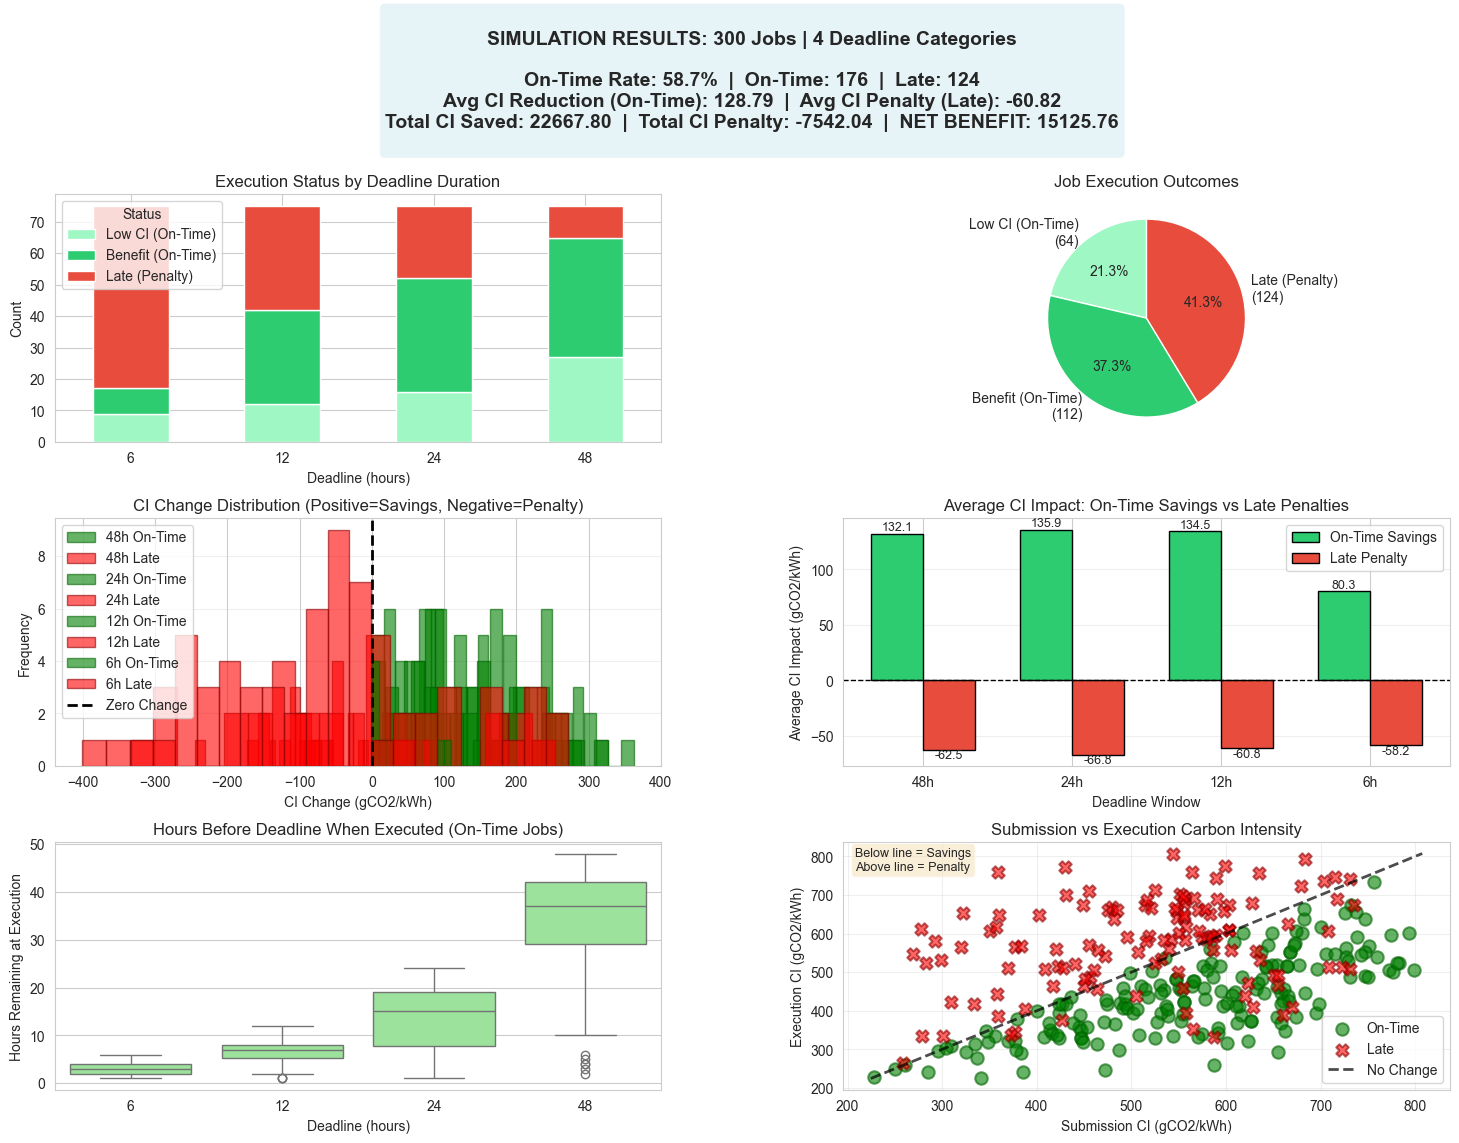


SIMULATION SUMMARY

Deadline: 48 hours
  Total jobs: 75
  On-time: 65 (86.7%)
    - Low CI: 27
    - Benefit: 38
  Late: 10 (13.3%)
  On-time CI savings: 132.13 avg, 8588.75 total
  Late CI penalty: -62.51 avg, -625.15 total
  NET BENEFIT: 7963.60 gCO2/kWh

Deadline: 24 hours
  Total jobs: 75
  On-time: 52 (69.3%)
    - Low CI: 16
    - Benefit: 36
  Late: 23 (30.7%)
  On-time CI savings: 135.86 avg, 7064.65 total
  Late CI penalty: -66.76 avg, -1535.37 total
  NET BENEFIT: 5529.28 gCO2/kWh

Deadline: 12 hours
  Total jobs: 75
  On-time: 42 (56.0%)
    - Low CI: 12
    - Benefit: 30
  Late: 33 (44.0%)
  On-time CI savings: 134.51 avg, 5649.56 total
  Late CI penalty: -60.84 avg, -2007.79 total
  NET BENEFIT: 3641.77 gCO2/kWh

Deadline: 6 hours
  Total jobs: 75
  On-time: 17 (22.7%)
    - Low CI: 9
    - Benefit: 8
  Late: 58 (77.3%)
  On-time CI savings: 80.28 avg, 1364.84 total
  Late CI penalty: -58.17 avg, -3373.73 total
  NET BENEFIT: -2008.89 gCO2/kWh

OVERALL NET BENEFIT: 15125.

In [23]:
# Disclosure: generative AI was used to help with plot creation
# Generate visuals
print("Creating visualization...")
print(f"Total results: {len(all_results)}")

# Create DataFrame
results_df = pd.DataFrame(all_results)

# Check what statuses we have
print(f"\nStatus distribution:")
print(results_df['status'].value_counts())

# Separate on-time vs late
ontime_df = results_df[results_df['status'].isin(['executed_low_CI', 'executed_benefit'])]
late_df = results_df[results_df['status'] == 'executed_late']
all_executed_df = results_df  # All jobs get executed eventually

print(f"\nOn-time: {len(ontime_df)}, Late: {len(late_df)}")

# Analysis and Visualization
fig = plt.figure(figsize=(18, 22))
gs = fig.add_gridspec(6, 2, height_ratios=[0.3, 1, 1, 1, 1, 1], hspace=0.35, wspace=0.3)

# Calculate headline metrics
total_jobs = len(results_df)
total_ontime = len(ontime_df)
total_late = len(late_df)
ontime_rate = (total_ontime / total_jobs) * 100 if total_jobs > 0 else 0

# CI metrics
avg_ci_ontime = ontime_df['CI_reduction'].mean() if len(ontime_df) > 0 else 0
avg_ci_late = late_df['CI_reduction'].mean() if len(late_df) > 0 else 0
total_ci_saved = ontime_df['CI_reduction'].sum() if len(ontime_df) > 0 else 0
total_ci_penalty = late_df['CI_reduction'].sum() if len(late_df) > 0 else 0
net_ci_benefit = total_ci_saved + total_ci_penalty

avg_hours_remaining_ontime = ontime_df['hours_to_deadline'].mean() if len(ontime_df) > 0 else 0

# Headline metrics panel
ax_summary = fig.add_subplot(gs[0, :])
ax_summary.axis('off')

metrics_text = f"""
SIMULATION RESULTS: {total_jobs} Jobs | {len(results_df['deadline_hours'].unique())} Deadline Categories

On-Time Rate: {ontime_rate:.1f}%  |  On-Time: {total_ontime}  |  Late: {total_late}
Avg CI Reduction (On-Time): {avg_ci_ontime:.2f}  |  Avg CI Penalty (Late): {avg_ci_late:.2f}
Total CI Saved: {total_ci_saved:.2f}  |  Total CI Penalty: {total_ci_penalty:.2f}  |  NET BENEFIT: {net_ci_benefit:.2f}
"""

ax_summary.text(0.5, 0.5, metrics_text, ha='center', va='center', 
                fontsize=14, fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),
        fig.add_subplot(gs[3, 0]), fig.add_subplot(gs[3, 1])]

# 1. Execution status by deadline
ax = axes[0]
try:
    # Count by status for each deadline
    deadline_status_counts = results_df.groupby(['deadline_hours', 'status']).size().unstack(fill_value=0)
    
    if len(deadline_status_counts) > 0:
        # Define colors
        colors_map = {
            'executed_low_CI': "#9FF7C4",
            'executed_benefit': '#2ecc71', 
            'executed_late': '#e74c3c'
        }
        
        # Get columns in the right order
        cols_available = [c for c in ['executed_low_CI', 'executed_benefit', 'executed_late'] 
                         if c in deadline_status_counts.columns]
        
        if cols_available:
            deadline_status_counts = deadline_status_counts[cols_available]
            colors = [colors_map[c] for c in cols_available]
            
            deadline_status_counts.plot(kind='bar', ax=ax, stacked=True, color=colors)
            
            # Better legend
            label_map = {
                'executed_low_CI': 'Low CI (On-Time)',
                'executed_benefit': 'Benefit (On-Time)',
                'executed_late': 'Late (Penalty)'
            }
            ax.legend(title='Status', labels=[label_map[c] for c in cols_available])
            ax.set_title('Execution Status by Deadline Duration')
            ax.set_xlabel('Deadline (hours)')
            ax.set_ylabel('Count')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        else:
            raise ValueError("No valid status columns")
    else:
        raise ValueError("No data")
except Exception as e:
    print(f"Warning: Could not create status bar chart: {e}")
    ax.text(0.5, 0.5, 'No data for status breakdown', ha='center', va='center', transform=ax.transAxes)

# 2. Job outcomes pie chart
ax = axes[1]
executed_low_ci = (results_df['status'] == 'executed_low_CI').sum()
executed_benefit = (results_df['status'] == 'executed_benefit').sum()
executed_late = (results_df['status'] == 'executed_late').sum()

outcomes = [executed_low_ci, executed_benefit, executed_late]
labels = [f'Low CI (On-Time)\n({executed_low_ci})', 
          f'Benefit (On-Time)\n({executed_benefit})', 
          f'Late (Penalty)\n({executed_late})']
colors = ["#9FF7C4", '#2ecc71', '#e74c3c']

# Filter out zeros
outcomes_nonzero = [(o, l, c) for o, l, c in zip(outcomes, labels, colors) if o > 0]
if outcomes_nonzero:
    outcomes, labels, colors = zip(*outcomes_nonzero)
    ax.pie(outcomes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title('Job Execution Outcomes')
else:
    ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

# 3. CI Reduction/Penalty Distribution
ax = axes[2]
deadline_hours = results_df['deadline_hours'].unique()

has_data = False
for deadline in deadline_hours:
    ontime_subset = ontime_df[ontime_df['deadline_hours'] == deadline]['CI_reduction'].dropna()
    late_subset = late_df[late_df['deadline_hours'] == deadline]['CI_reduction'].dropna()
    
    if len(ontime_subset) > 0:
        ax.hist(ontime_subset, alpha=0.6, label=f'{deadline}h On-Time', bins=20, color='green', edgecolor='darkgreen')
        has_data = True
    if len(late_subset) > 0:
        ax.hist(late_subset, alpha=0.6, label=f'{deadline}h Late', bins=20, color='red', edgecolor='darkred')
        has_data = True

if has_data:
    ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Change')
    ax.set_title('CI Change Distribution (Positive=Savings, Negative=Penalty)')
    ax.set_xlabel('CI Change (gCO2/kWh)')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No CI data', ha='center', va='center', transform=ax.transAxes)

# 4. Average CI impact by deadline
ax = axes[3]
ci_data = []
for deadline in deadline_hours:
    ontime_subset = ontime_df[ontime_df['deadline_hours'] == deadline]['CI_reduction'].dropna()
    late_subset = late_df[late_df['deadline_hours'] == deadline]['CI_reduction'].dropna()
    
    avg_ontime = ontime_subset.mean() if len(ontime_subset) > 0 else 0
    avg_late = late_subset.mean() if len(late_subset) > 0 else 0
    
    ci_data.append({
        'deadline': f'{deadline}h',
        'On-Time Savings': avg_ontime,
        'Late Penalty': avg_late
    })

if ci_data:
    ci_impact_df = pd.DataFrame(ci_data)
    x = np.arange(len(ci_impact_df))
    width = 0.35

    bars1 = ax.bar(x - width/2, ci_impact_df['On-Time Savings'], width, 
                   label='On-Time Savings', color='#2ecc71', edgecolor='black')
    bars2 = ax.bar(x + width/2, ci_impact_df['Late Penalty'], width, 
                   label='Late Penalty', color='#e74c3c', edgecolor='black')

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        if abs(height) > 0.1:  # Only label if significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        if abs(height) > 0.1:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='top' if height < 0 else 'bottom', fontsize=9)

    ax.set_xlabel('Deadline Window')
    ax.set_ylabel('Average CI Impact (gCO2/kWh)')
    ax.set_title('Average CI Impact: On-Time Savings vs Late Penalties')
    ax.set_xticks(x)
    ax.set_xticklabels(ci_impact_df['deadline'])
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No CI data', ha='center', va='center', transform=ax.transAxes)

# 5. Execution timing (on-time jobs only)
ax = axes[4]
if len(ontime_df) > 0:
    timing_df = ontime_df.dropna(subset=['hours_to_deadline'])
    if len(timing_df) > 0:
        sns.boxplot(data=timing_df, x='deadline_hours', y='hours_to_deadline', ax=ax, color='lightgreen')
        ax.set_title('Hours Before Deadline When Executed (On-Time Jobs)')
        ax.set_xlabel('Deadline (hours)')
        ax.set_ylabel('Hours Remaining at Execution')
    else:
        ax.text(0.5, 0.5, 'No timing data', ha='center', va='center', transform=ax.transAxes)
else:
    ax.text(0.5, 0.5, 'No on-time executions', ha='center', va='center', transform=ax.transAxes)

# 6. Submission CI vs Execution CI scatter (ALL jobs)
ax = axes[5]
all_with_ci = results_df.dropna(subset=['CI_at_schedule', 'execution_CI'])
if len(all_with_ci) > 0:
    ontime_with_ci = all_with_ci[all_with_ci['status'].isin(['executed_low_CI', 'executed_benefit'])]
    late_with_ci = all_with_ci[all_with_ci['status'] == 'executed_late']
    
    if len(ontime_with_ci) > 0:
        ax.scatter(ontime_with_ci['CI_at_schedule'], 
                  ontime_with_ci['execution_CI'], 
                  alpha=0.6, s=80, c='green', 
                  edgecolors='darkgreen', linewidth=1.5,
                  label='On-Time', marker='o')
    
    if len(late_with_ci) > 0:
        ax.scatter(late_with_ci['CI_at_schedule'], 
                  late_with_ci['execution_CI'], 
                  alpha=0.6, s=80, c='red', 
                  edgecolors='darkred', linewidth=1.5,
                  label='Late', marker='X')
    
    min_ci = all_with_ci[['CI_at_schedule', 'execution_CI']].min().min()
    max_ci = all_with_ci[['CI_at_schedule', 'execution_CI']].max().max()
    ax.plot([min_ci, max_ci], [min_ci, max_ci], 'k--', linewidth=2, label='No Change', alpha=0.7)
    
    ax.set_xlabel('Submission CI (gCO2/kWh)')
    ax.set_ylabel('Execution CI (gCO2/kWh)')
    ax.set_title('Submission vs Execution Carbon Intensity')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax.text(0.02, 0.98, 'Below line = Savings\nAbove line = Penalty', 
            transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    ax.text(0.5, 0.5, 'No CI comparison data', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('results/scheduler_simulation_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to 'scheduler_simulation_results.png'")
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)

for deadline in deadline_hours:
    subset = results_df[results_df['deadline_hours'] == deadline]
    ontime_subset = subset[subset['status'].isin(['executed_low_CI', 'executed_benefit'])]
    late_subset = subset[subset['status'] == 'executed_late']
    
    print(f"\nDeadline: {deadline} hours")
    print(f"  Total jobs: {len(subset)}")
    print(f"  On-time: {len(ontime_subset)} ({len(ontime_subset)/len(subset)*100:.1f}%)")
    print(f"    - Low CI: {(subset['status'] == 'executed_low_CI').sum()}")
    print(f"    - Benefit: {(subset['status'] == 'executed_benefit').sum()}")
    print(f"  Late: {len(late_subset)} ({len(late_subset)/len(subset)*100:.1f}%)")
    
    if len(ontime_subset) > 0:
        print(f"  On-time CI savings: {ontime_subset['CI_reduction'].mean():.2f} avg, {ontime_subset['CI_reduction'].sum():.2f} total")
    
    if len(late_subset) > 0:
        print(f"  Late CI penalty: {late_subset['CI_reduction'].mean():.2f} avg, {late_subset['CI_reduction'].sum():.2f} total")
    
    if len(subset) > 0:
        net = subset['CI_reduction'].sum()
        print(f"  NET BENEFIT: {net:.2f} gCO2/kWh")

print("\n" + "="*60)
print(f"OVERALL NET BENEFIT: {results_df['CI_reduction'].sum():.2f} gCO2/kWh")
print("="*60)

results_df.to_csv('results/scheduler_simulation_results.csv', index=False)
print("\nResults saved to 'results/scheduler_simulation_results.csv'")

In [24]:
import collections
reasons = collections.Counter()
remaining_when_executed = []

for r in all_results:
    if r['status'] in ('executed', 'executed_at_low_CI'):
        remaining_when_executed.append(r['hours_to_deadline'])

# Quick summary counts
print("TOTAL JOBS:", len(all_results))
cnts = collections.Counter([r['status'] for r in all_results])
print("STATUS COUNTS:", dict(cnts))
if remaining_when_executed:
    print("Executed median hours before deadline: {:.2f}, mean: {:.2f}".format(
        np.median(remaining_when_executed), np.mean(remaining_when_executed)))


TOTAL JOBS: 300
STATUS COUNTS: {'executed_late': 124, 'executed_low_CI': 64, 'executed_benefit': 112}
